# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of grapes and olives production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).


In [2]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [4]:
grapes_olives = pd.read_csv('./Italy_crop_data/grapes_olives.csv',skipinitialspace=True)
grapes_olives.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2006,2006,125000.0,NaN,NaN
1,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2007,2007,30702.0,NaN,NaN
2,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2008,2008,145292.0,NaN,NaN
3,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2009,2009,100000.0,NaN,NaN
4,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2010,2010,95459.0,e,estimate data


## Pre-processing dataset 

In [5]:
# Drop Columns
grapes_olives = grapes_olives.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
grapes_olives

,Territory,Data type,Type of crop,Select time,Value
0,Pisa,harvested production - quintals,oil olives,2006,125000.0
1,Pisa,harvested production - quintals,oil olives,2007,30702.0
2,Pisa,harvested production - quintals,oil olives,2008,145292.0
3,Pisa,harvested production - quintals,oil olives,2009,100000.0
4,Pisa,harvested production - quintals,oil olives,2010,95459.0
...,...,...,...,...,...
17616,Valle d'Aosta / Vallée d'Aoste,production area - hectares,other olives,2021,1.0
17617,Valle d'Aosta / Vallée d'Aoste,total production - quintals,other olives,2021,40.0
17618,Valle d'Aosta / Vallée d'Aoste,harvested production - quintals,other olives,2021,40.0
17619,Milano,production area - hectares,other olives,2021,2.0


In [6]:
# Rename Columns
grapes_olives = grapes_olives.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [7]:
grapes_olives.Type_crop.unique()

array(['oil olives', 'Grapes for table use', 'olive oil', 'wine',
       'table olives',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)',
       'grapes for other purposes n.e.c.', 'grapes for raisins',
       'table winw', 'whithe wine', 'must', 'red and rosé wine',
       'registered designation of origin wine',
       'registered designation of origin white wine',
       'registered designation of origin black wine',
       'typical geographical indication wine',
       'typical geographical indication white wine',
       'typical geographical indication black wine', 'other olives'],
      dtype=object)

In [11]:
grapes_olives =grapes_olives.replace('table and oil olives', 'table olives')
grapes_olives =grapes_olives.replace('oil olives', 'olive oil')

In [12]:
grapes_olives 

,City,Data_type,Type_crop,Year,Value
0,Pisa,harvested production - quintals,olive oil,2006,125000.0
1,Pisa,harvested production - quintals,olive oil,2007,30702.0
2,Pisa,harvested production - quintals,olive oil,2008,145292.0
3,Pisa,harvested production - quintals,olive oil,2009,100000.0
4,Pisa,harvested production - quintals,olive oil,2010,95459.0
...,...,...,...,...,...
17616,Valle d'Aosta / Vallée d'Aoste,production area - hectares,other olives,2021,1.0
17617,Valle d'Aosta / Vallée d'Aoste,total production - quintals,other olives,2021,40.0
17618,Valle d'Aosta / Vallée d'Aoste,harvested production - quintals,other olives,2021,40.0
17619,Milano,production area - hectares,other olives,2021,2.0


In [13]:
grapes_olives.Type_crop.unique()

array(['olive oil', 'Grapes for table use', 'wine', 'table olives',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)',
       'grapes for other purposes n.e.c.', 'grapes for raisins',
       'table winw', 'whithe wine', 'must', 'red and rosé wine',
       'registered designation of origin wine',
       'registered designation of origin white wine',
       'registered designation of origin black wine',
       'typical geographical indication wine',
       'typical geographical indication white wine',
       'typical geographical indication black wine', 'other olives'],
      dtype=object)

In [14]:
def show_info(grapes_olives):
    print('DATASET SHAPE: ', grapes_olives.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(grapes_olives.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(grapes_olives.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(grapes_olives.isnull().sum())
show_info(grapes_olives)

DATASET SHAPE:  (17621, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17621 entries, 0 to 17620
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       17621 non-null  object 
 1   Data_type  17621 non-null  object 
 2   Type_crop  17621 non-null  object 
 3   Year       17621 non-null  int64  
 4   Value      17621 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 688.4+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          109
Data_type       6
Type_crop      20
Year           17
Value        6524
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing grapes and olives crop

In [ ]:
#grapes_olives.City.unique()


## Select only values for total grapes and olives crop production - quintals


In [15]:
grapes_olives_prod = grapes_olives[grapes_olives['Data_type'] == 'total production - quintals ']
grapes_olives_prod.head()

,City,Data_type,Type_crop,Year,Value
60,Lucca,total production - quintals,wine,2006,54310.0
61,Lucca,total production - quintals,wine,2007,46900.0
62,Lucca,total production - quintals,wine,2008,45208.0
63,Lucca,total production - quintals,wine,2009,44900.0
64,Lucca,total production - quintals,wine,2010,34580.0


In [16]:
grapes_olives_prod = grapes_olives_prod.rename(columns = {'Value':'Total_production'})
grapes_olives_prod

,City,Data_type,Type_crop,Year,Total_production
60,Lucca,total production - quintals,wine,2006,54310.0
61,Lucca,total production - quintals,wine,2007,46900.0
62,Lucca,total production - quintals,wine,2008,45208.0
63,Lucca,total production - quintals,wine,2009,44900.0
64,Lucca,total production - quintals,wine,2010,34580.0
...,...,...,...,...,...
17601,Barletta-Andria-Trani,total production - quintals,other olives,2020,1050000.0
17602,Barletta-Andria-Trani,total production - quintals,other olives,2021,1040000.0
17609,Sud Sardegna,total production - quintals,other olives,2020,82202.0
17610,Sud Sardegna,total production - quintals,other olives,2021,108310.0


In [17]:
grapes_olives_prod = grapes_olives_prod.drop(columns =['Data_type'])
grapes_olives_prod

,City,Type_crop,Year,Total_production
60,Lucca,wine,2006,54310.0
61,Lucca,wine,2007,46900.0
62,Lucca,wine,2008,45208.0
63,Lucca,wine,2009,44900.0
64,Lucca,wine,2010,34580.0
...,...,...,...,...
17601,Barletta-Andria-Trani,other olives,2020,1050000.0
17602,Barletta-Andria-Trani,other olives,2021,1040000.0
17609,Sud Sardegna,other olives,2020,82202.0
17610,Sud Sardegna,other olives,2021,108310.0


## Total grapes and olives crop production in 2006-2022

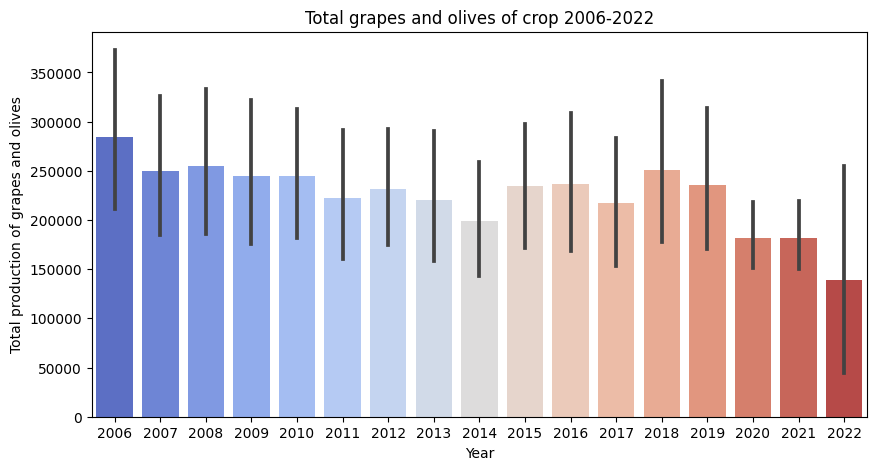

In [18]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = grapes_olives_prod, palette='coolwarm')
plt.title('Total grapes and olives of crop 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production of grapes and olives')
plt.show()



## Grapes and olives crop production by Cities 

In [19]:
grapes_olives_prod_region = grapes_olives_prod.groupby(by = grapes_olives_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
grapes_olives_prod_region



,City,Total_production
33,Foggia,77076643.0
92,Taranto,70853236.0
7,Bari,69061728.0
97,Treviso,62999433.0
105,Verona,51882927.0
...,...,...
103,Verbano-Cusio-Ossola,32863.0
47,Lodi,23035.0
24,Como,16831.0
101,Varese,13498.0


In [20]:
region = grapes_olives_prod_region.nlargest(30, 'Total_production')

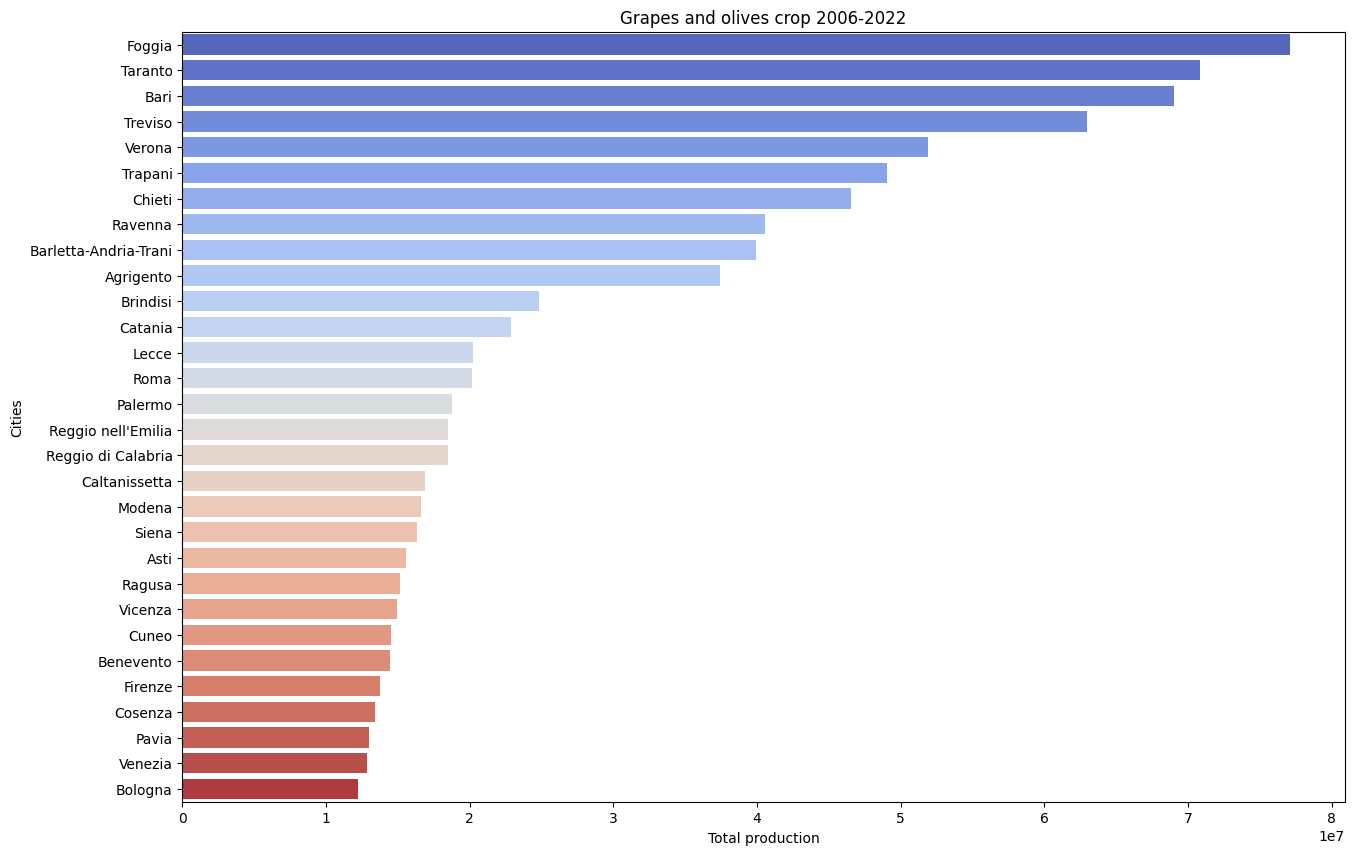

In [21]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Grapes and olives crop 2006-2022 by city')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show() 

##  Grapes and olives production  2020-2022

In [22]:
print(grapes_olives_prod.Type_crop.max())
print(grapes_olives_prod.Type_crop.value_counts())
print(grapes_olives_prod.Type_crop.nunique())



wine
olive oil                                                        1682
wine                                                             1478
Grapes for table use                                             1064
grapes for other wines n.e.c. (without pdo/pgi)                   210
other olives                                                      197
grapes for wines with protected designation of origin (pdo)       194
grapes for wines with protected geographical indication (pgi)     184
table olives                                                      113
grapes for other purposes n.e.c.                                   12
grapes for raisins                                                  2
Name: Type_crop, dtype: int64
10


Dataset shows there are 10 different types of grapes and olives cultivated in Italy. The top most produced crops are :  Wine grapes, Table olives, Grapes for other wines, Grapes for table use ,Olive oil, Grapes for wines with protected designation of origin (pdo), Grapes for wines with protected geographical indication (pgi),Grapes for other wines n.e.c. (without pdo/pgi), Grapes for raisins, Grapes for other purposes n.e.c., Other olives,


In [25]:
grapes_olives_prod = grapes_olives_prod.replace('Grapes for table use','grapes-table')
grapes_olives_prod = grapes_olives_prod.replace('grapes for other purposes n.e.c.','grapes-n.e.c')
grapes_olives_prod = grapes_olives_prod.replace('grapes for raisins','grapes-raisins')
grapes_olives_prod = grapes_olives_prod.replace('grapes for other wines n.e.c. (without pdo/pgi)','grapes-wines(N-pdo/pgi)')
grapes_olives_prod = grapes_olives_prod.replace('grapes for wines with protected designation of origin (pdo)','grapes-wines(Y-pdo)')
grapes_olives_prod = grapes_olives_prod.replace('grapes for wines with protected geographical indication (pgi)','grapes-wines(Y-pgi)')

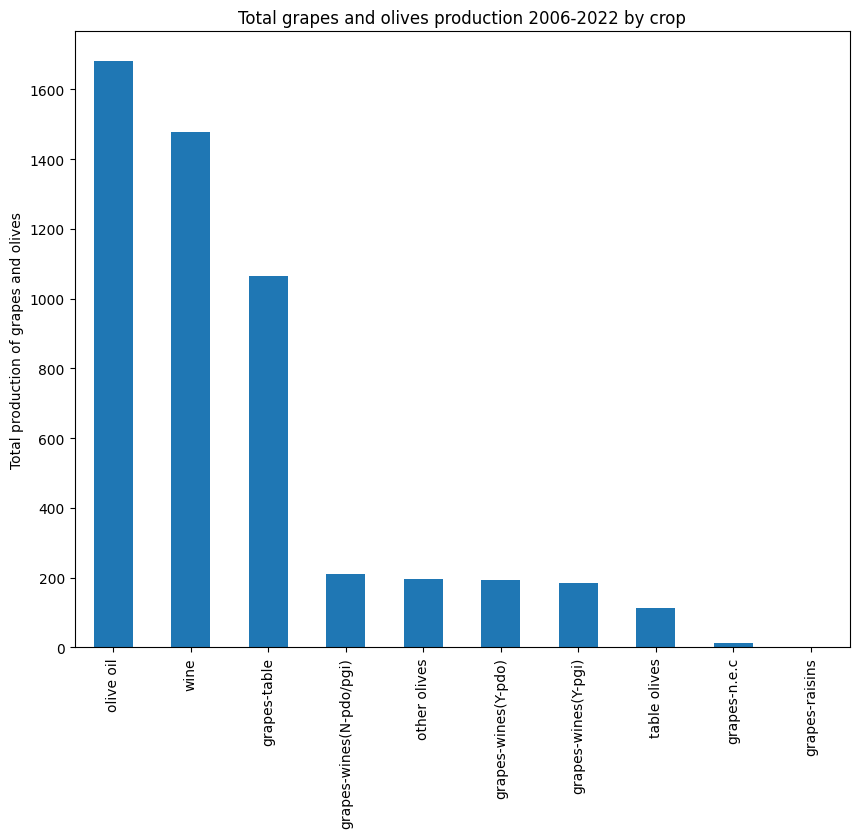

In [26]:
plt.figure(figsize=(10,8))
grapes_olives_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total grapes and olives production 2006-2022 by crop')
plt.ylabel('Total production of grapes and olives')
plt.show()


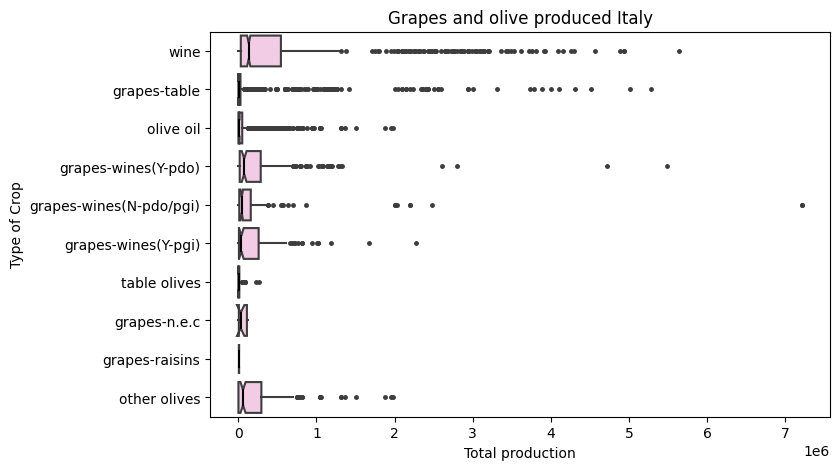

In [27]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=grapes_olives_prod, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Grapes and olive produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

## Vizualization of ten type of grapes and olives produced in Italy in the period of 2006-2022 

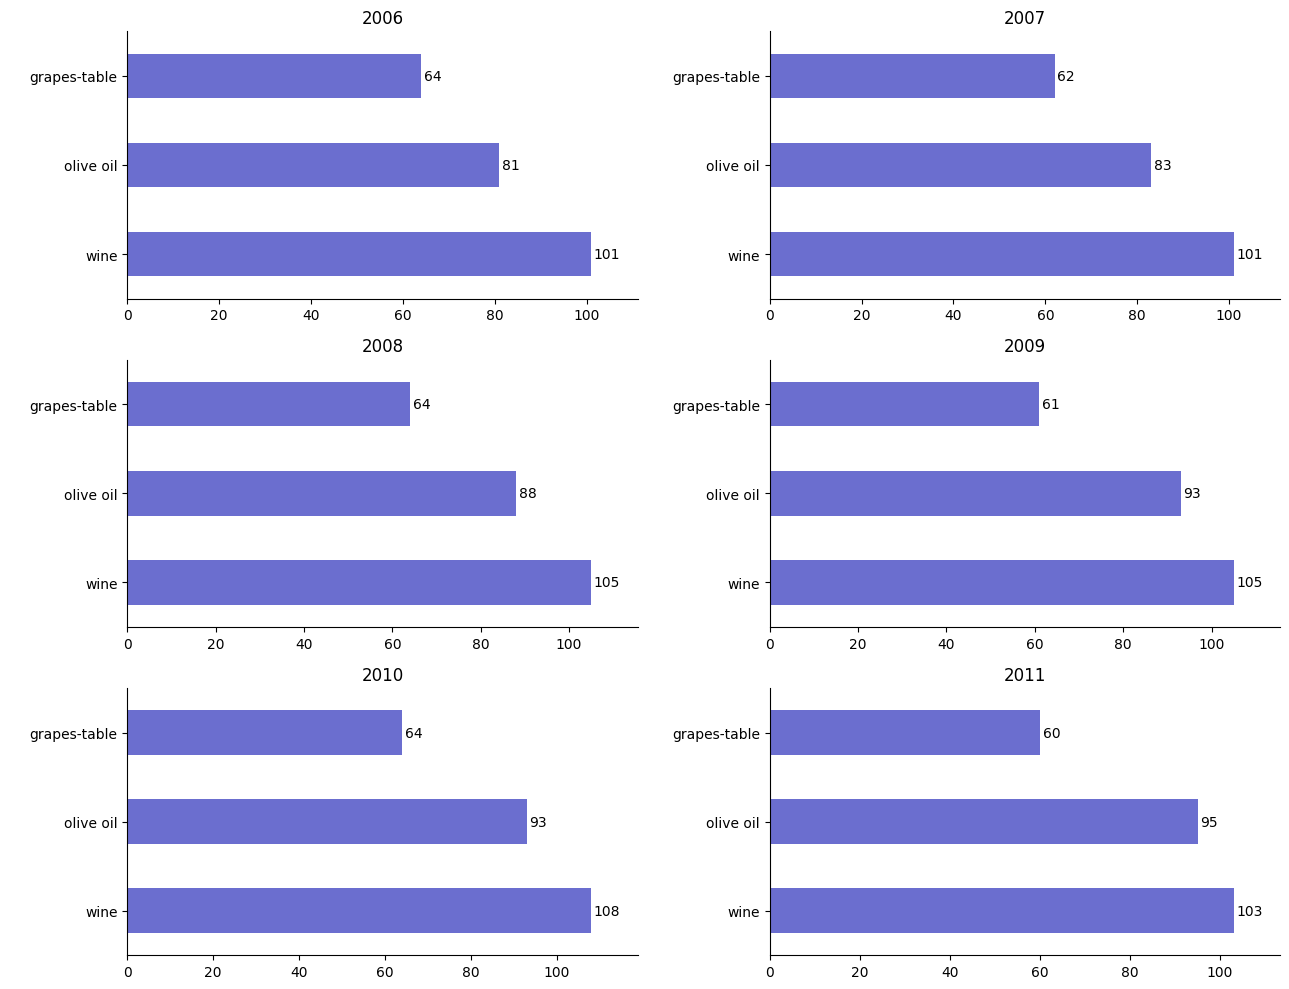

In [28]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))
plt.ylabel(" ")

plot1 = grapes_olives_prod[grapes_olives_prod.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2006', ax=axs[0,0])
plot2 = grapes_olives_prod[grapes_olives_prod.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2007', ax=axs[0,1])
plot3 = grapes_olives_prod[grapes_olives_prod.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2008', ax=axs[1,0])
plot4 = grapes_olives_prod[grapes_olives_prod.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2009', ax=axs[1,1])
plot5 = grapes_olives_prod[grapes_olives_prod.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2010', ax=axs[2,0])
plot6 = grapes_olives_prod[grapes_olives_prod.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2011', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()
plt.show()




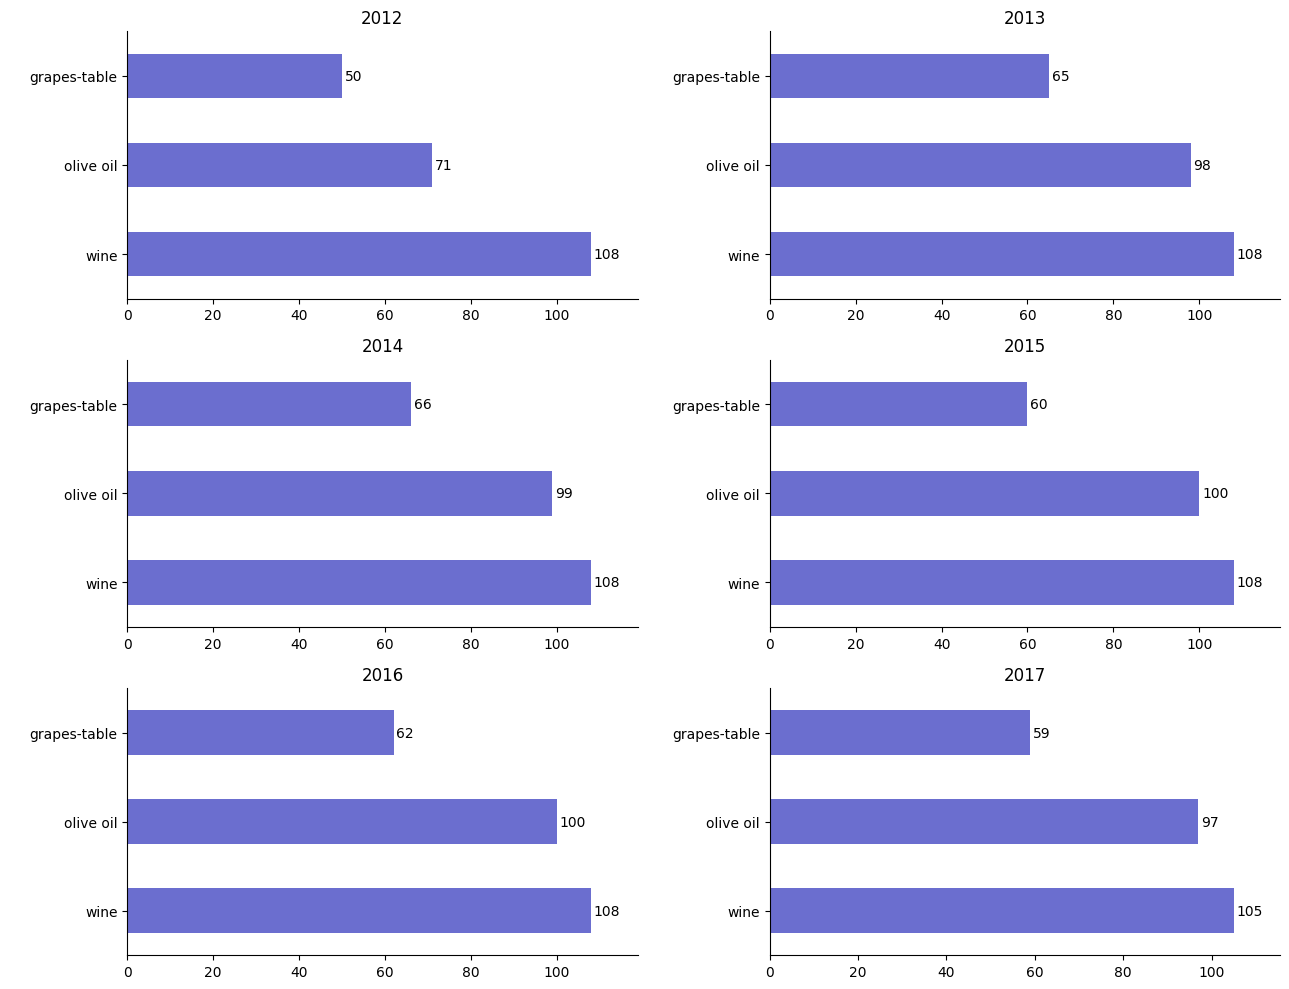

In [33]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))


plot7 = grapes_olives_prod[grapes_olives_prod.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2012', ax=axs[0,0])
plot8 = grapes_olives_prod[grapes_olives_prod.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2013', ax=axs[0,1])
plot9 = grapes_olives_prod[grapes_olives_prod.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2014', ax=axs[1,0])
plot10 = grapes_olives_prod[grapes_olives_prod.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2015', ax=axs[1,1])
plot11 = grapes_olives_prod[grapes_olives_prod.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2016', ax=axs[2,0])
plot12 = grapes_olives_prod[grapes_olives_prod.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2017', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()
    
plt.tight_layout()
plt.show()

IndexError: list index out of range

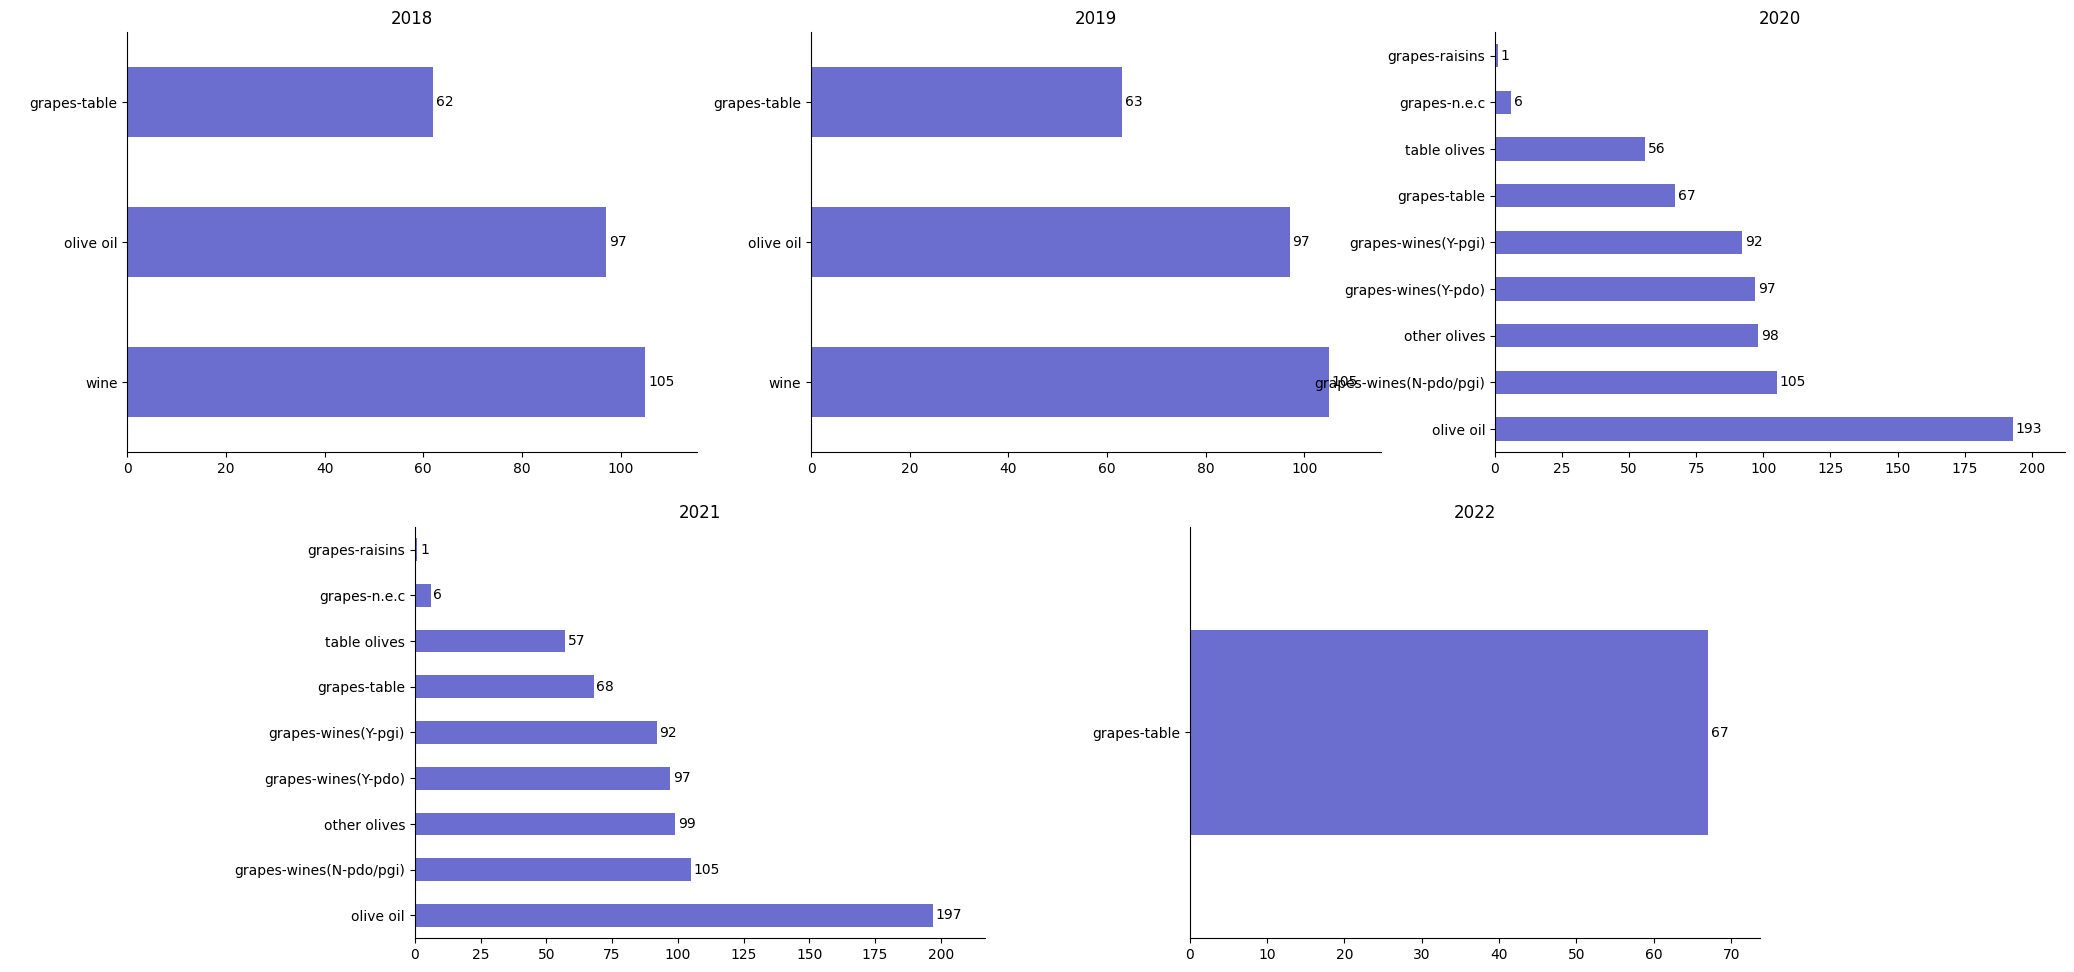

In [34]:
fig, axs = plt.subplots(2,3, figsize=(25,12))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)

plot13 = grapes_olives_prod[grapes_olives_prod.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2018', ax=axs[0,0])
plot14 = grapes_olives_prod[grapes_olives_prod.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2019', ax=axs[0,1])
plot15 = grapes_olives_prod[grapes_olives_prod.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2020', ax=axs[0,2])
plot16 = grapes_olives_prod[grapes_olives_prod.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1,0])
plot17 = grapes_olives_prod[grapes_olives_prod.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2022', ax=axs[1,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()

plt.show()


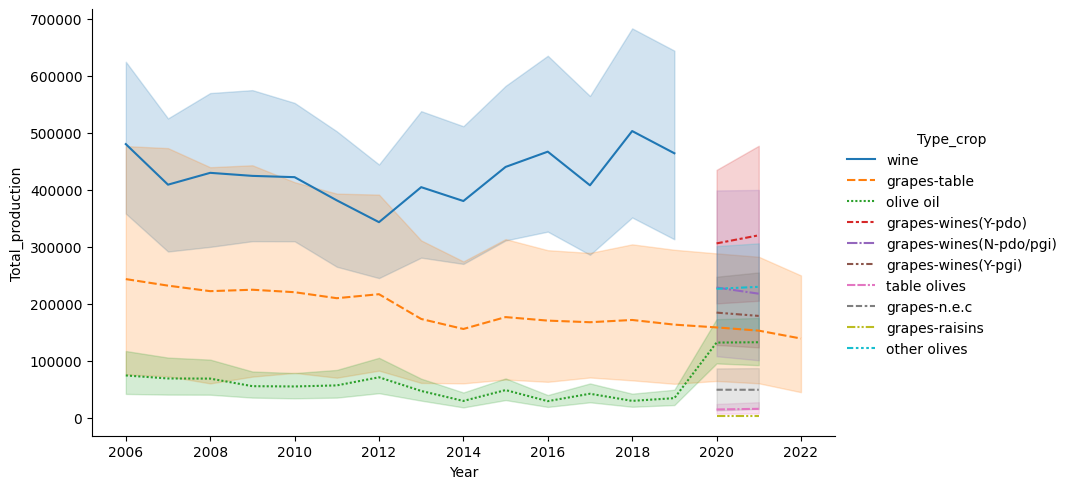

In [35]:
#Crop harvested by year
plotcrop = sns.relplot(kind='line', data=grapes_olives_prod, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


There relplot shows that some crops were cultivated under special certification: Protected designation of Origin (PDO) and Protected Geographic Origin (PGI) for the years 2020-2021. 

### Create columns for each type crop 

In [38]:
# Create columns for each type crop
grapes_olives_pivot = grapes_olives_prod.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
grapes_olives_pivot

Total_production                              \
Type_crop          grapes-n.e.c grapes-raisins grapes-table   
City      Year                                                
Agrigento 2006              NaN            NaN    1417500.0   
          2007              NaN            NaN    1265213.0   
          2008              NaN            NaN    1266300.0   
          2009              NaN            NaN    1223000.0   
          2010              NaN            NaN     846000.0   
...                         ...            ...          ...   
Viterbo   2018              NaN            NaN          NaN   
          2019              NaN            NaN       1040.0   
          2020              NaN            NaN       1100.0   
          2021              NaN            NaN       1010.0   
          2022              NaN            NaN       1050.0   

                                                            \
Type_crop      grapes-wines(N-pdo/pgi) grapes-wines(Y-pdo)   
City      Year                                               
Agrigento 2006                     NaN                 NaN   
          2007                     NaN                 NaN   
          2008                     NaN                 NaN   
          2009                     NaN                 NaN   
          2010                     NaN                 NaN   
...                                ...                 ...   
Viterbo   2018                     NaN                 NaN   
          2019                     NaN                 NaN   
          2020                 26500.0             75000.0   
          2021                 27980.0             78800.0   
          2022                     NaN                 NaN   

                                                                        \
Type_crop      grapes-wines(Y-pgi) olive oil other olives table olives   
City      Year                                                           
Agrigento 2006                 NaN   92870.0          NaN          NaN   
          2007                 NaN   95100.0          NaN          NaN   
          2008                 NaN  106400.0          NaN          NaN   
          2009                 NaN   83000.0          NaN          NaN   
          2010                 NaN   76000.0          NaN          NaN   
...                            ...       ...          ...          ...   
Viterbo   2018                 NaN   19000.0          NaN          NaN   
          2019                 NaN   21500.0          NaN          NaN   
          2020            105600.0  245650.0     221000.0          NaN   
          2021            115000.0  241900.0     218000.0          NaN   
          2022                 NaN       NaN          NaN          NaN   

                           
Type_crop            wine  
City      Year             
Agrigento 2006  1190000.0  
          2007   622700.0  
          2008   753001.0  
          2009  1096670.0  
          2010   763500.0  
...                   ...  
Viterbo   2018    81800.0  
          2019   147760.0  
          2020        NaN  
          2021        NaN  
          2022        NaN  

[1760 rows x 10 columns]

In [39]:
# Drop level
grapes_olives_pivot.columns = grapes_olives_pivot.columns.droplevel()
grapes_olives_pivot

Type_crop       grapes-n.e.c  grapes-raisins  grapes-table  \
City      Year                                               
Agrigento 2006           NaN             NaN     1417500.0   
          2007           NaN             NaN     1265213.0   
          2008           NaN             NaN     1266300.0   
          2009           NaN             NaN     1223000.0   
          2010           NaN             NaN      846000.0   
...                      ...             ...           ...   
Viterbo   2018           NaN             NaN           NaN   
          2019           NaN             NaN        1040.0   
          2020           NaN             NaN        1100.0   
          2021           NaN             NaN        1010.0   
          2022           NaN             NaN        1050.0   

Type_crop       grapes-wines(N-pdo/pgi)  grapes-wines(Y-pdo)  \
City      Year                                                 
Agrigento 2006                      NaN                  NaN   
          2007                      NaN                  NaN   
          2008                      NaN                  NaN   
          2009                      NaN                  NaN   
          2010                      NaN                  NaN   
...                                 ...                  ...   
Viterbo   2018                      NaN                  NaN   
          2019                      NaN                  NaN   
          2020                  26500.0              75000.0   
          2021                  27980.0              78800.0   
          2022                      NaN                  NaN   

Type_crop       grapes-wines(Y-pgi)  olive oil  other olives  table olives  \
City      Year                                                               
Agrigento 2006                  NaN    92870.0           NaN           NaN   
          2007                  NaN    95100.0           NaN           NaN   
          2008                  NaN   106400.0           NaN           NaN   
          2009                  NaN    83000.0           NaN           NaN   
          2010                  NaN    76000.0           NaN           NaN   
...                             ...        ...           ...           ...   
Viterbo   2018                  NaN    19000.0           NaN           NaN   
          2019                  NaN    21500.0           NaN           NaN   
          2020             105600.0   245650.0      221000.0           NaN   
          2021             115000.0   241900.0      218000.0           NaN   
          2022                  NaN        NaN           NaN           NaN   

Type_crop            wine  
City      Year             
Agrigento 2006  1190000.0  
          2007   622700.0  
          2008   753001.0  
          2009  1096670.0  
          2010   763500.0  
...                   ...  
Viterbo   2018    81800.0  
          2019   147760.0  
          2020        NaN  
          2021        NaN  
          2022        NaN  

[1760 rows x 10 columns]

In [40]:
grapes_olives_pivot = grapes_olives_pivot.fillna(0)
grapes_olives_pivot

Type_crop       grapes-n.e.c  grapes-raisins  grapes-table  \
City      Year                                               
Agrigento 2006           0.0             0.0     1417500.0   
          2007           0.0             0.0     1265213.0   
          2008           0.0             0.0     1266300.0   
          2009           0.0             0.0     1223000.0   
          2010           0.0             0.0      846000.0   
...                      ...             ...           ...   
Viterbo   2018           0.0             0.0           0.0   
          2019           0.0             0.0        1040.0   
          2020           0.0             0.0        1100.0   
          2021           0.0             0.0        1010.0   
          2022           0.0             0.0        1050.0   

Type_crop       grapes-wines(N-pdo/pgi)  grapes-wines(Y-pdo)  \
City      Year                                                 
Agrigento 2006                      0.0                  0.0   
          2007                      0.0                  0.0   
          2008                      0.0                  0.0   
          2009                      0.0                  0.0   
          2010                      0.0                  0.0   
...                                 ...                  ...   
Viterbo   2018                      0.0                  0.0   
          2019                      0.0                  0.0   
          2020                  26500.0              75000.0   
          2021                  27980.0              78800.0   
          2022                      0.0                  0.0   

Type_crop       grapes-wines(Y-pgi)  olive oil  other olives  table olives  \
City      Year                                                               
Agrigento 2006                  0.0    92870.0           0.0           0.0   
          2007                  0.0    95100.0           0.0           0.0   
          2008                  0.0   106400.0           0.0           0.0   
          2009                  0.0    83000.0           0.0           0.0   
          2010                  0.0    76000.0           0.0           0.0   
...                             ...        ...           ...           ...   
Viterbo   2018                  0.0    19000.0           0.0           0.0   
          2019                  0.0    21500.0           0.0           0.0   
          2020             105600.0   245650.0      221000.0           0.0   
          2021             115000.0   241900.0      218000.0           0.0   
          2022                  0.0        0.0           0.0           0.0   

Type_crop            wine  
City      Year             
Agrigento 2006  1190000.0  
          2007   622700.0  
          2008   753001.0  
          2009  1096670.0  
          2010   763500.0  
...                   ...  
Viterbo   2018    81800.0  
          2019   147760.0  
          2020        0.0  
          2021        0.0  
          2022        0.0  

[1760 rows x 10 columns]

In [41]:
#Rename index
grapes_olives_pivot = grapes_olives_pivot.rename_axis(None,axis=1)
grapes_olives_pivot

grapes-n.e.c  grapes-raisins  grapes-table  \
City      Year                                               
Agrigento 2006           0.0             0.0     1417500.0   
          2007           0.0             0.0     1265213.0   
          2008           0.0             0.0     1266300.0   
          2009           0.0             0.0     1223000.0   
          2010           0.0             0.0      846000.0   
...                      ...             ...           ...   
Viterbo   2018           0.0             0.0           0.0   
          2019           0.0             0.0        1040.0   
          2020           0.0             0.0        1100.0   
          2021           0.0             0.0        1010.0   
          2022           0.0             0.0        1050.0   

                grapes-wines(N-pdo/pgi)  grapes-wines(Y-pdo)  \
City      Year                                                 
Agrigento 2006                      0.0                  0.0   
          2007                      0.0                  0.0   
          2008                      0.0                  0.0   
          2009                      0.0                  0.0   
          2010                      0.0                  0.0   
...                                 ...                  ...   
Viterbo   2018                      0.0                  0.0   
          2019                      0.0                  0.0   
          2020                  26500.0              75000.0   
          2021                  27980.0              78800.0   
          2022                      0.0                  0.0   

                grapes-wines(Y-pgi)  olive oil  other olives  table olives  \
City      Year                                                               
Agrigento 2006                  0.0    92870.0           0.0           0.0   
          2007                  0.0    95100.0           0.0           0.0   
          2008                  0.0   106400.0           0.0           0.0   
          2009                  0.0    83000.0           0.0           0.0   
          2010                  0.0    76000.0           0.0           0.0   
...                             ...        ...           ...           ...   
Viterbo   2018                  0.0    19000.0           0.0           0.0   
          2019                  0.0    21500.0           0.0           0.0   
          2020             105600.0   245650.0      221000.0           0.0   
          2021             115000.0   241900.0      218000.0           0.0   
          2022                  0.0        0.0           0.0           0.0   

                     wine  
City      Year             
Agrigento 2006  1190000.0  
          2007   622700.0  
          2008   753001.0  
          2009  1096670.0  
          2010   763500.0  
...                   ...  
Viterbo   2018    81800.0  
          2019   147760.0  
          2020        0.0  
          2021        0.0  
          2022        0.0  

[1760 rows x 10 columns]

In [42]:
# Reset index
grapes_olives_pivot = grapes_olives_pivot.reset_index()
grapes_olives_pivot

,City,Year,grapes-n.e.c,grapes-raisins,grapes-table,grapes-wines(N-pdo/pgi),grapes-wines(Y-pdo),grapes-wines(Y-pgi),olive oil,other olives,table olives,wine
0,Agrigento,2006,0.0,0.0,1417500.0,0.0,0.0,0.0,92870.0,0.0,0.0,1190000.0
1,Agrigento,2007,0.0,0.0,1265213.0,0.0,0.0,0.0,95100.0,0.0,0.0,622700.0
2,Agrigento,2008,0.0,0.0,1266300.0,0.0,0.0,0.0,106400.0,0.0,0.0,753001.0
3,Agrigento,2009,0.0,0.0,1223000.0,0.0,0.0,0.0,83000.0,0.0,0.0,1096670.0
4,Agrigento,2010,0.0,0.0,846000.0,0.0,0.0,0.0,76000.0,0.0,0.0,763500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1755,Viterbo,2018,0.0,0.0,0.0,0.0,0.0,0.0,19000.0,0.0,0.0,81800.0
1756,Viterbo,2019,0.0,0.0,1040.0,0.0,0.0,0.0,21500.0,0.0,0.0,147760.0
1757,Viterbo,2020,0.0,0.0,1100.0,26500.0,75000.0,105600.0,245650.0,221000.0,0.0,0.0
1758,Viterbo,2021,0.0,0.0,1010.0,27980.0,78800.0,115000.0,241900.0,218000.0,0.0,0.0


## Estatistical analysis

In [43]:
grapes_olives_pivot.describe()

,Year,grapes-n.e.c,grapes-raisins,grapes-table,grapes-wines(N-pdo/pgi),grapes-wines(Y-pdo),grapes-wines(Y-pgi),olive oil,other olives,table olives,wine
count,1760.000000,1760.000000,1760.000000,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1760.000000,1.760000e+03
mean,2013.849432,336.627841,3.181818,1.132662e+05,2.662356e+04,3.450127e+04,1.899466e+04,6.591048e+04,2.552843e+04,988.114773,3.569861e+05
std,4.769925,5666.179594,94.361147,4.626426e+05,2.785886e+05,2.360986e+05,1.137876e+05,1.864402e+05,1.428116e+05,10153.728544,6.772357e+05
min,2006.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,2010.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01,0.000000e+00,0.000000,9.943750e+03
50%,2014.000000,0.000000,0.000000,7.500000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+03,0.000000e+00,0.000000,8.314600e+04
75%,2018.000000,0.000000,0.000000,5.600000e+03,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+04,0.000000e+00,0.000000,4.106250e+05
max,2022.000000,120000.000000,2800.000000,5.278000e+06,7.214500e+06,5.484399e+06,2.268000e+06,2.362674e+06,1.975480e+06,270000.000000,5.645184e+06


#### Data metrics : skew, kurtosis and mode

In [48]:
grapes_olives_pivot_stats = grapes_olives_pivot[['olive oil', 'wine','grapes-table','grapes-wines(N-pdo/pgi)',
                                                 'other olives','grapes-wines(Y-pgi)','table olives',
                                                 'grapes-raisins','grapes-n.e.c','grapes-wines(Y-pdo)']]
print(grapes_olives_pivot_stats.astype(float).skew())
print(grapes_olives_pivot_stats.astype(float).kurtosis())
print(grapes_olives_pivot_stats.astype(float).mode())

olive oil                   6.147127
wine                        3.494591
grapes-table                6.167703
grapes-wines(N-pdo/pgi)    21.157959
other olives                8.273968
grapes-wines(Y-pgi)        10.127581
table olives               18.684751
grapes-raisins             29.639472
grapes-n.e.c               19.128154
grapes-wines(Y-pdo)        14.327817
dtype: float64
olive oil                   51.997003
wine                        14.503914
grapes-table                45.363615
grapes-wines(N-pdo/pgi)    514.799558
other olives                82.867166
grapes-wines(Y-pgi)        138.818217
table olives               426.851479
grapes-raisins             877.495447
grapes-n.e.c               378.392725
grapes-wines(Y-pdo)        271.714297
dtype: float64
   olive oil  wine  grapes-table  grapes-wines(N-pdo/pgi)  other olives  \
0        0.0   0.0           0.0                      0.0           0.0   

   grapes-wines(Y-pgi)  table olives  grapes-raisins  grapes-n.e.c  \

## Graphs

#### Histogram and Boxplot showing data distribuion and outliers¶
 
Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [49]:
Q1 = grapes_olives_pivot_stats.quantile(0.25)
Q3 = grapes_olives_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


olive oil                   41963.00
wine                       400681.25
grapes-table                 5600.00
grapes-wines(N-pdo/pgi)         0.00
other olives                    0.00
grapes-wines(Y-pgi)             0.00
table olives                    0.00
grapes-raisins                  0.00
grapes-n.e.c                    0.00
grapes-wines(Y-pdo)             0.00
dtype: float64


### Remove outliers and plot graphs

In [50]:
# Remove outliers
grapes_olives_pivot_stats[~((grapes_olives_pivot < (Q1 - 1.5 * IQR)) | (grapes_olives_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]
print(grapes_olives_pivot_stats.shape)

(1760, 10)


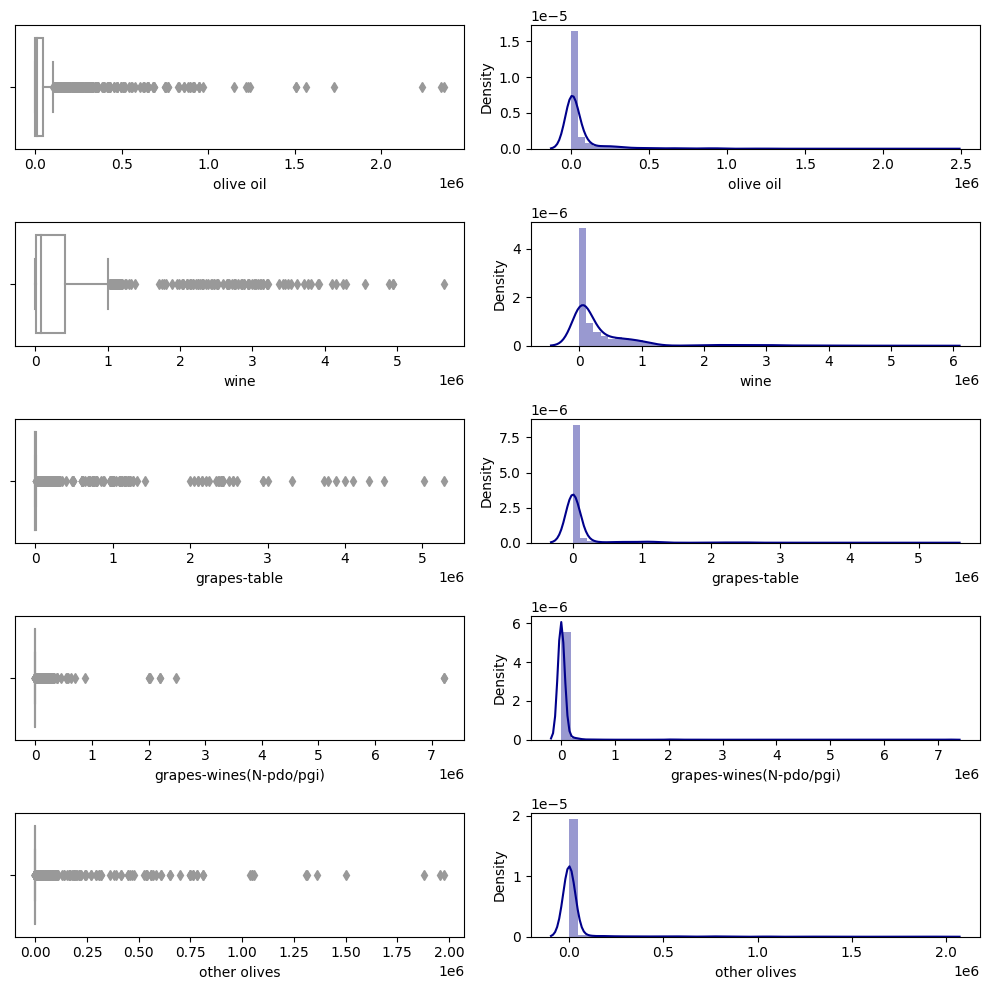

In [51]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= grapes_olives_pivot_stats["olive oil"], color = 'white', ax = ax[0,0])
sns.distplot(grapes_olives_pivot_stats['olive oil'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= grapes_olives_pivot_stats["wine"],color = 'white', ax = ax[1,0])
sns.distplot(grapes_olives_pivot_stats['wine'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-table"],color = 'white', ax = ax[2,0])
sns.distplot(grapes_olives_pivot_stats['grapes-table'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-wines(N-pdo/pgi)"], color = 'white', ax = ax[3,0])
sns.distplot(grapes_olives_pivot_stats['grapes-wines(N-pdo/pgi)'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= grapes_olives_pivot_stats["other olives"], color = 'white',ax = ax[4,0])
sns.distplot(grapes_olives_pivot_stats['other olives'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

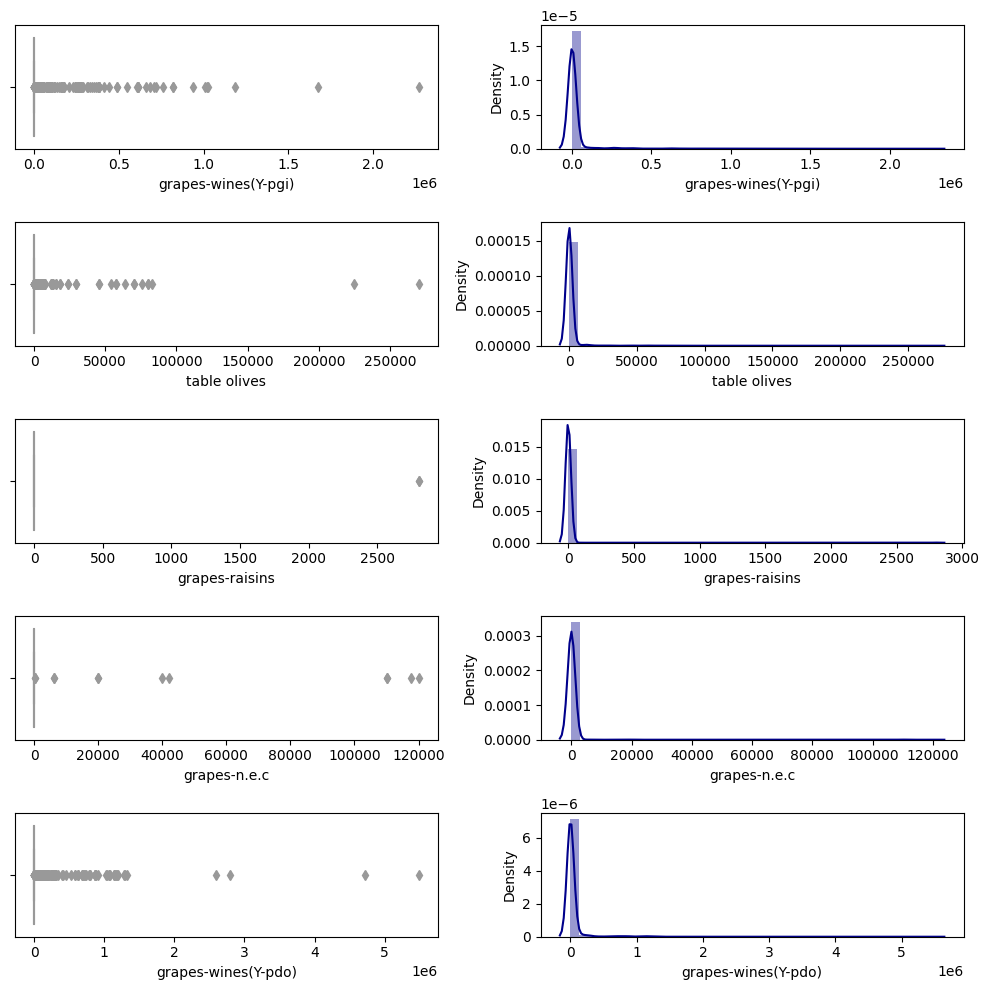

In [53]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= grapes_olives_pivot_stats["grapes-wines(Y-pgi)"], color = 'white', ax = ax[0,0])
sns.distplot(grapes_olives_pivot_stats['grapes-wines(Y-pgi)'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= grapes_olives_pivot_stats["table olives"],color = 'white', ax = ax[1,0])
sns.distplot(grapes_olives_pivot_stats['table olives'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-raisins"],color = 'white', ax = ax[2,0])
sns.distplot(grapes_olives_pivot_stats['grapes-raisins'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-n.e.c"], color = 'white',ax = ax[3,0])
sns.distplot(grapes_olives_pivot_stats['grapes-n.e.c'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-wines(Y-pdo)"], color = 'white',ax = ax[4,0])
sns.distplot(grapes_olives_pivot_stats['grapes-wines(Y-pdo)'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

### Pre-processing ferlizers dataset
fertilizers distributed - tonnes

In [54]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [55]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags'])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [56]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [57]:
fertilizer.City.unique()

array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Imperia', 'Savona', 'Genova', 'La Spezia', 'Varese', 'Como',
       'Lecco', 'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia',
       'Lodi', 'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento',
       'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova',
       'Rovigo', 'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza',
       'Parma', "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara',
       'Ravenna', 'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca',
       'Pistoia', 'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo',
       'Siena', 'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino',
       'Ancona', 'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma',
       'Latina', 'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       

In [58]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [59]:
#fertilizer = fertilizer[fertilizer['Data_type'] == 'fertilizers distributed - quintals']
#fertilizer.head()

In [60]:
# drop column 
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335
68382,Sud Sardegna,specific action products -,2018,137
68383,Sud Sardegna,specific action products -,2019,164
68384,Sud Sardegna,specific action products -,2020,135


In [61]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [62]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

### Selecting fertilizers for future analysis 

In [63]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [64]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [65]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54


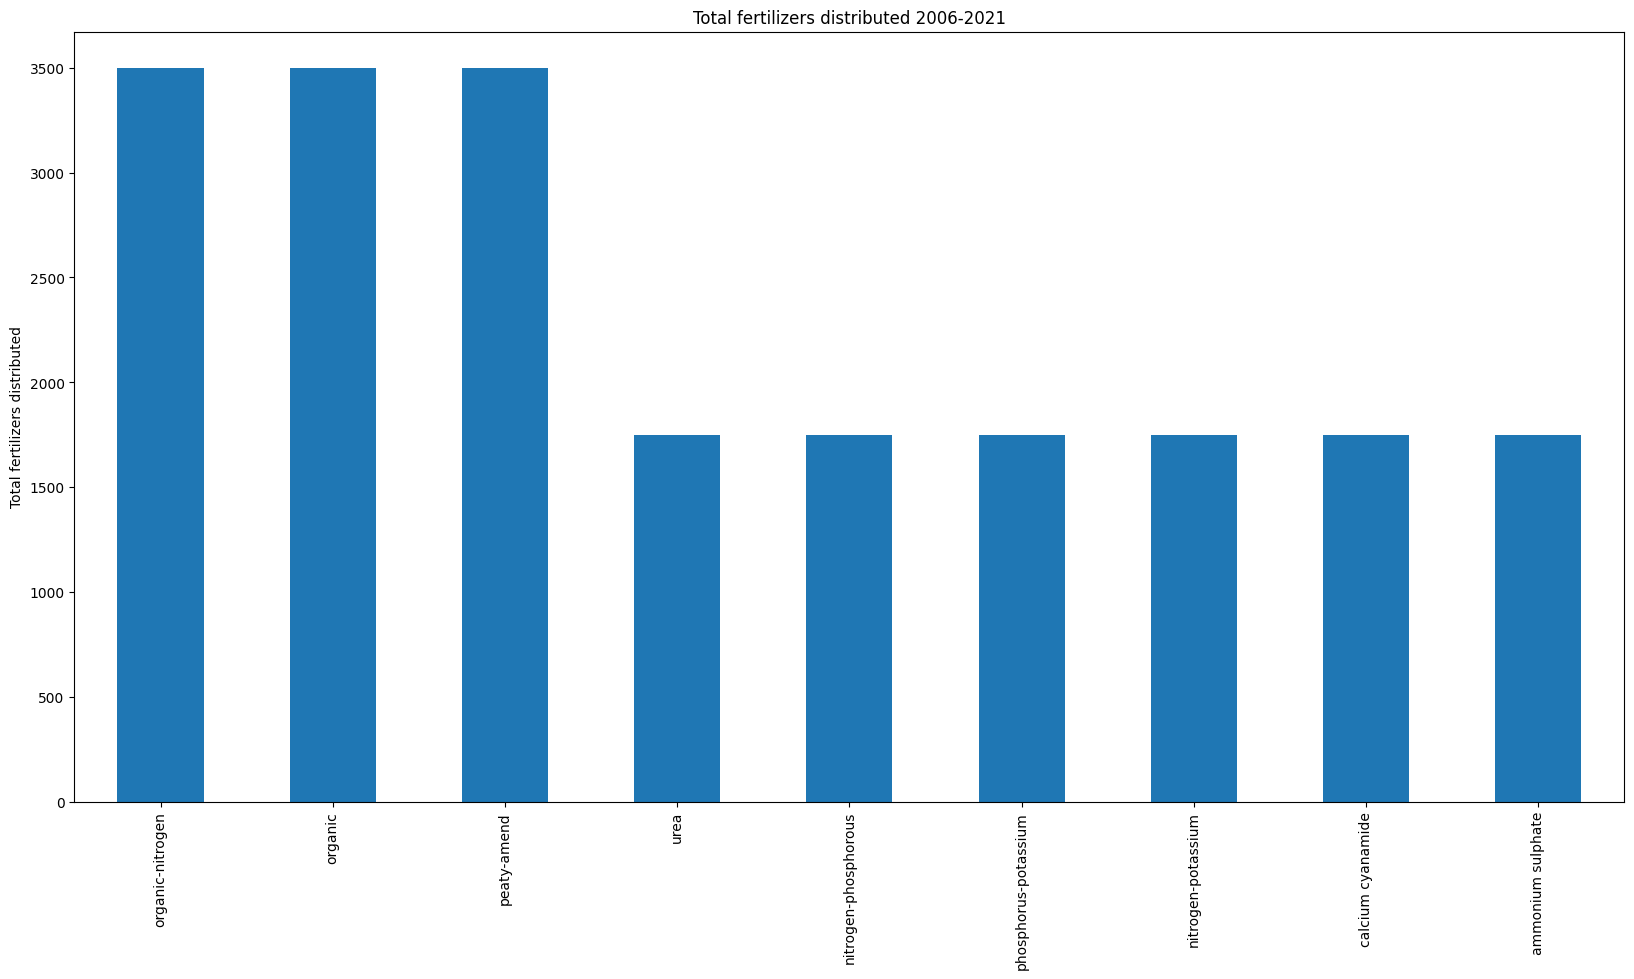

In [66]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers distributed')
plt.show()

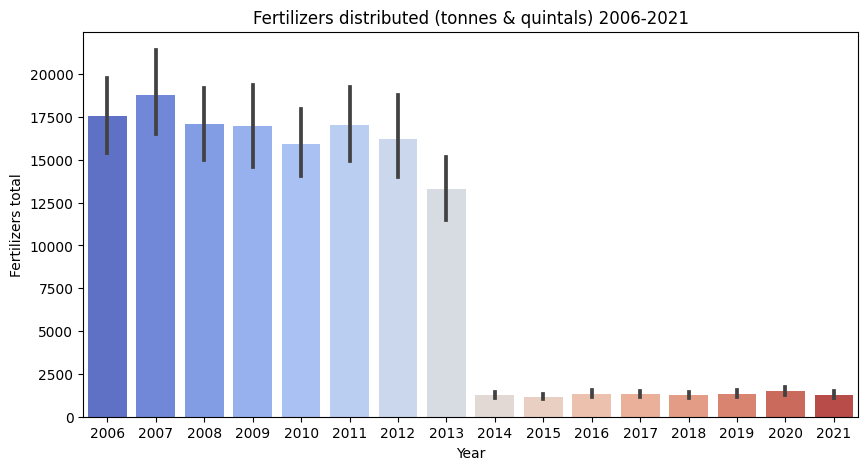

In [67]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


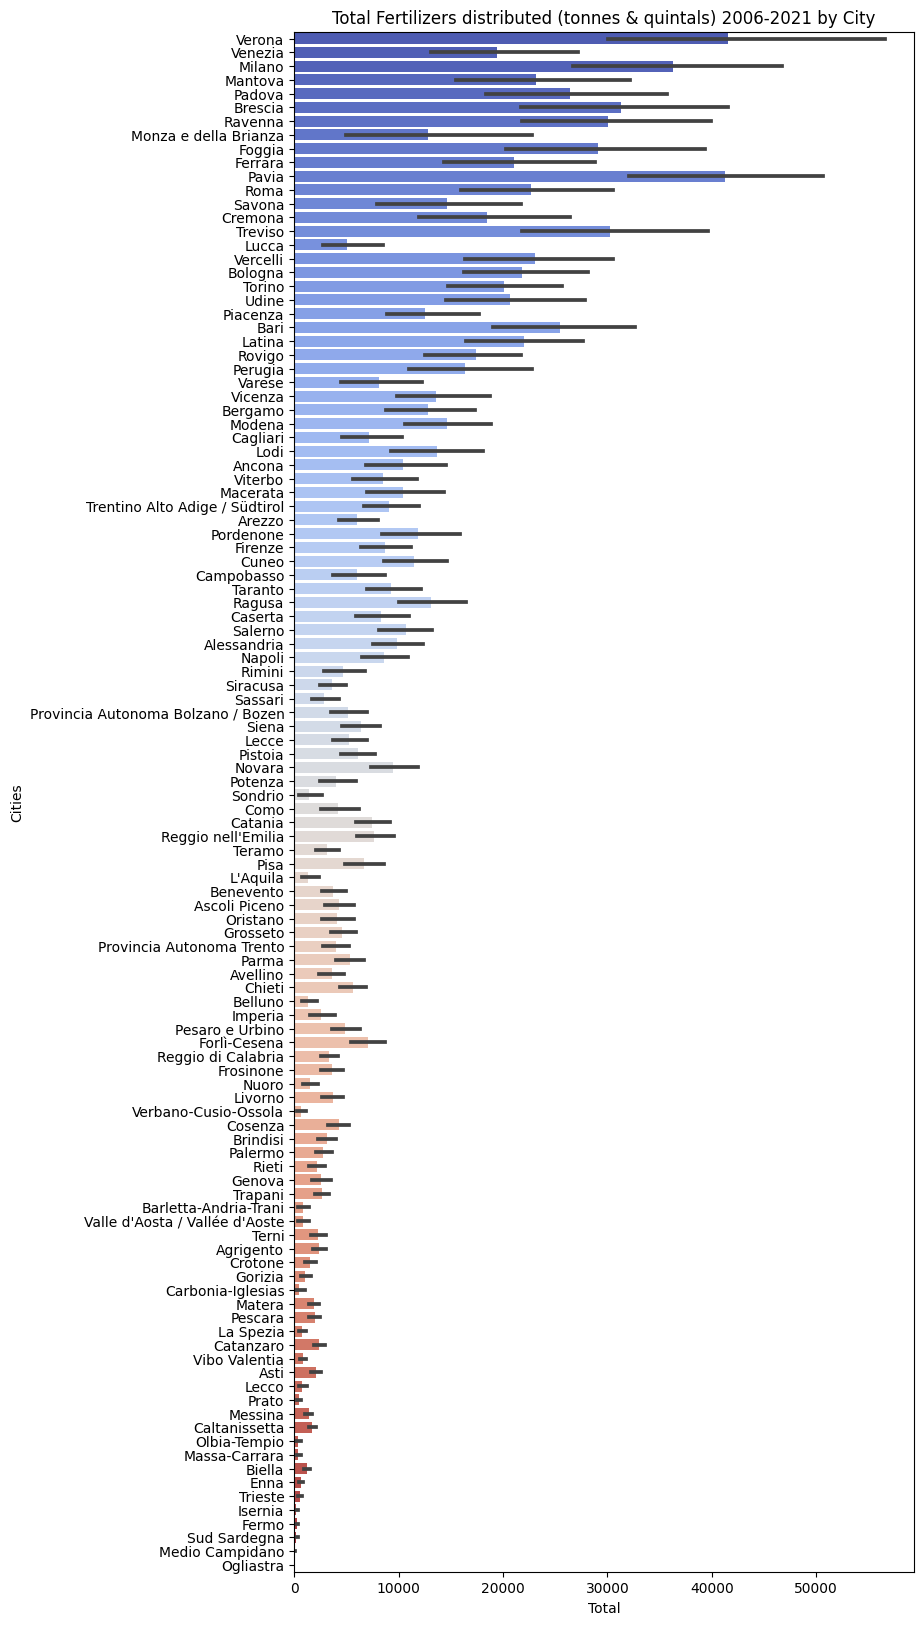

In [68]:
fertilizer= fertilizer.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,20))
sns.barplot(x=fertilizer['Fertilizers_tonnes'] ,y= fertilizer ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

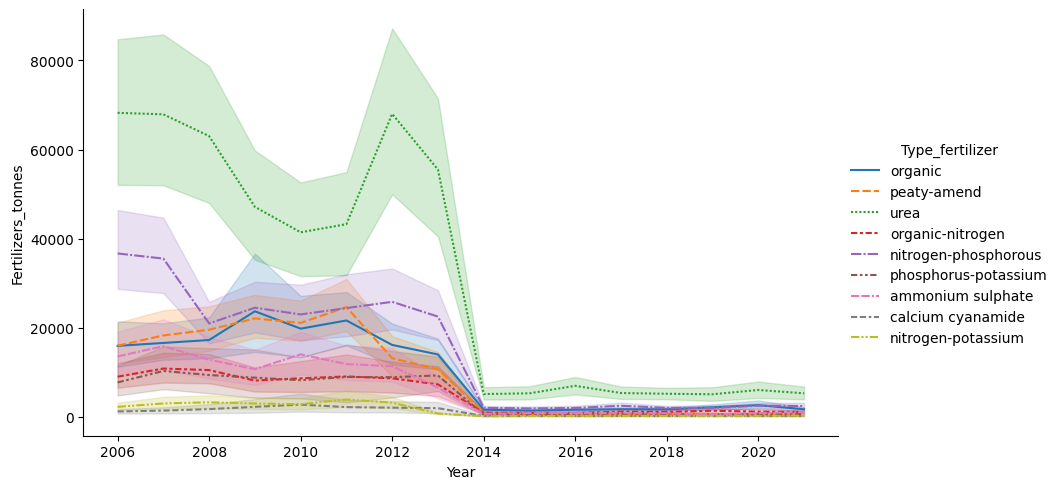

In [69]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [71]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
8734,Verona,organic,2009,986716
9983,Venezia,organic,2010,500556
5532,Milano,peaty-amend,2007,460504
7390,Mantova,organic,2009,453752
8731,Verona,organic,2006,392359


### Create new dataframe with the selected type of fertilizers as columns


In [72]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006              1687.0               0.0               4977.0   
          2007              2171.0               0.0               6498.0   
          2008              1400.0               0.0               5213.0   
          2009              1404.0               0.0               3808.0   
          2010              1416.0             140.0               3271.0   
...                            ...               ...                  ...   
Viterbo   2017               153.0               0.0               4732.0   
          2018               149.0               0.0               4376.0   
          2019                70.0               0.0               3964.0   
          2020               176.0               0.0               6145.0   
          2021               152.0               0.0               3946.0   

                                                                          \
Type_fertilizer nitrogen-potassium  organic organic-nitrogen peaty-amend   
City      Year                                                             
Agrigento 2006               277.0  31439.0           7779.0      2966.0   
          2007               491.0  35348.0           6079.0      2949.0   
          2008               614.0  37504.0          14075.0      3506.0   
          2009               468.0  27914.0           8984.0      5678.0   
          2010               440.0  23460.0           9136.0      3082.0   
...                            ...      ...              ...         ...   
Viterbo   2017                66.0   1760.0           2268.0       274.0   
          2018                19.0   1591.0           2106.0       811.0   
          2019               195.0   1251.0           2884.0       427.0   
          2020                98.0   1236.0           2935.0       275.0   
          2021               112.0   1056.0           3337.0       131.0   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [73]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006              1687.0                0.0                4977.0   
          2007              2171.0                0.0                6498.0   
          2008              1400.0                0.0                5213.0   
          2009              1404.0                0.0                3808.0   
          2010              1416.0              140.0                3271.0   
...                            ...                ...                   ...   
Viterbo   2017               153.0                0.0                4732.0   
          2018               149.0                0.0                4376.0   
          2019                70.0                0.0                3964.0   
          2020               176.0                0.0                6145.0   
          2021               152.0                0.0                3946.0   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006                277.0  31439.0            7779.0       2966.0   
          2007                491.0  35348.0            6079.0       2949.0   
          2008                614.0  37504.0           14075.0       3506.0   
          2009                468.0  27914.0            8984.0       5678.0   
          2010                440.0  23460.0            9136.0       3082.0   
...                             ...      ...               ...          ...   
Viterbo   2017                 66.0   1760.0            2268.0        274.0   
          2018                 19.0   1591.0            2106.0        811.0   
          2019                195.0   1251.0            2884.0        427.0   
          2020                 98.0   1236.0            2935.0        275.0   
          2021                112.0   1056.0            3337.0        131.0   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                 2093.0  2100.0  
          2007                 2953.0  5100.0  
          2008                 4438.0  2736.0  
          2009                 3590.0  2716.0  
          2010                 3506.0  2962.0  
...                               ...     ...  
Viterbo   2017                  179.0  2859.0  
          2018                   91.0  2863.0  
          2019                   95.0  2413.0  
          2020                  119.0  3578.0  
          2021                  126.0  2054.0  

[1749 rows x 9 columns]

In [74]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006             1687.0                0.0                4977.0   
          2007             2171.0                0.0                6498.0   
          2008             1400.0                0.0                5213.0   
          2009             1404.0                0.0                3808.0   
          2010             1416.0              140.0                3271.0   
...                           ...                ...                   ...   
Viterbo   2017              153.0                0.0                4732.0   
          2018              149.0                0.0                4376.0   
          2019               70.0                0.0                3964.0   
          2020              176.0                0.0                6145.0   
          2021              152.0                0.0                3946.0   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006               277.0  31439.0            7779.0       2966.0   
          2007               491.0  35348.0            6079.0       2949.0   
          2008               614.0  37504.0           14075.0       3506.0   
          2009               468.0  27914.0            8984.0       5678.0   
          2010               440.0  23460.0            9136.0       3082.0   
...                            ...      ...               ...          ...   
Viterbo   2017                66.0   1760.0            2268.0        274.0   
          2018                19.0   1591.0            2106.0        811.0   
          2019               195.0   1251.0            2884.0        427.0   
          2020                98.0   1236.0            2935.0        275.0   
          2021               112.0   1056.0            3337.0        131.0   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [75]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.0,0.0,4732.0,66.0,1760.0,2268.0,274.0,179.0,2859.0
1745,Viterbo,2018,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1746,Viterbo,2019,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1747,Viterbo,2020,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0


#### Join crop and fertilizers datasets

In [76]:
# Join both datasets 
it_crop_ferlizer = pd.merge(grapes_olives_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,grapes-n.e.c,grapes-raisins,grapes-table,grapes-wines(N-pdo/pgi),grapes-wines(Y-pdo),grapes-wines(Y-pgi),olive oil,other olives,...,wine,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,0.0,0.0,1417500.0,0.0,0.0,0.0,92870.0,0.0,...,1190000.0,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,0.0,0.0,1265213.0,0.0,0.0,0.0,95100.0,0.0,...,622700.0,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,0.0,0.0,1266300.0,0.0,0.0,0.0,106400.0,0.0,...,753001.0,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,0.0,0.0,1223000.0,0.0,0.0,0.0,83000.0,0.0,...,1096670.0,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,0.0,0.0,846000.0,0.0,0.0,0.0,76000.0,0.0,...,763500.0,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,Viterbo,2018,0.0,0.0,0.0,0.0,0.0,0.0,19000.0,0.0,...,81800.0,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1756,Viterbo,2019,0.0,0.0,1040.0,0.0,0.0,0.0,21500.0,0.0,...,147760.0,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1757,Viterbo,2020,0.0,0.0,1100.0,26500.0,75000.0,105600.0,245650.0,221000.0,...,0.0,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0
1758,Viterbo,2021,0.0,0.0,1010.0,27980.0,78800.0,115000.0,241900.0,218000.0,...,0.0,152.0,0.0,3946.0,112.0,1056.0,3337.0,131.0,126.0,2054.0


### Correlation 


In [79]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['olive oil', 'wine','grapes-table','grapes-wines(N-pdo/pgi)', 
                     'other olives','grapes-wines(Y-pgi)','table olives','grapes-raisins',
                     'calcium cyanamide','nitrogen-potassium','organic',
                      'phosphorus-potassium','urea']]


<AxesSubplot: title={'center': 'Correlation'}>

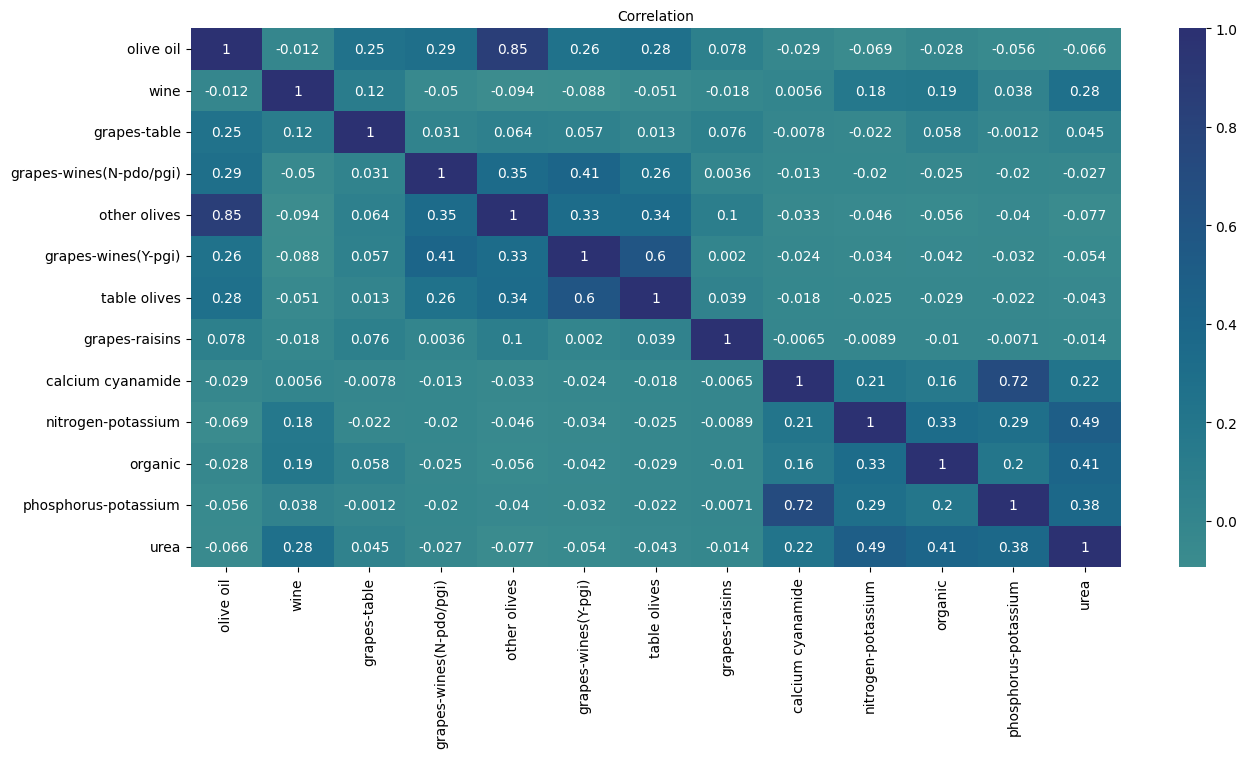

In [80]:
plt.figure(figsize=(15,7))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of grapes and olives production in Italy 

* Wine grapes has low correlation with urea, organic and nitrogen-potassium fertilizers.

* Olive oil has hight correlation with other olives, and low correlation with grapes and fertilizers.

* Grapes for table has low correlation with other crops and fertilizers.

* Grapes for wine no POD/PGI has correlation with Grapes with PGI and Olives.

* Table olives has high correlation with  Grapes with PGI. 

* Grapes for raisins and other purposes has low and negative correlation with fertilizers.

* There is also hight correlation between phosphorus-potassium with calcium.


### Calculating Variance Inflation Factor (VIF) for all given features

In [81]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [82]:
# Features selection
selected_features = ['olive oil', 'wine','grapes-table','grapes-wines(N-pdo/pgi)', 
                     'other olives','grapes-wines(Y-pgi)','table olives','grapes-raisins',
                     'calcium cyanamide','nitrogen-potassium','organic',
                      'phosphorus-potassium','urea']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
4,other olives,4.485829
0,olive oil,4.405142
11,phosphorus-potassium,2.322958
8,calcium cyanamide,2.083245
5,grapes-wines(Y-pgi),1.785544
12,urea,1.654532
6,table olives,1.624531
9,nitrogen-potassium,1.391071
3,grapes-wines(N-pdo/pgi),1.274674
10,organic,1.249177


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html